In [1]:
import sys
sys.path.append('../Phase_2')
from Phase_2 import Phase2Pipeline

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve
from sklearn.utils import resample

# === Load Classifier and Regressors ===
classifier = joblib.load('../Phase_2/stage_classifier_pipeline.pkl')
rf_model = joblib.load('../Phase_3/random_forest_model.pkl')
ridge_model = joblib.load('../Phase_3/ridge_model.pkl')
svr_model = joblib.load('../Phase_3/svr_model.pkl')

# === Load Test Data ===
X_test = pd.read_csv('../Phase_3/X_test.csv')
y_test = pd.read_csv('../Phase_3/y_test.csv')


In [3]:
# === Define Risk Score and Normalization Functions ===
def calculate_urgency_score(stage_4_prob, avg_time_left, epsilon=1e-6):
    return stage_4_prob / (avg_time_left + epsilon)

def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score + 1e-6)

In [4]:
# === Feature Selection ===
classifier_features = [
    'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 7', 'Sensor 9', 'Sensor 11',
    'Sensor 12', 'Sensor 14', 'Sensor 15', 'Sensor 17', 'Sensor 20', 'Sensor 21'
]
X_test_classifier = X_test[classifier_features]
X_test_regressors = X_test  # all features

In [5]:
# # Predict Failure Probabilities
stage_probs = classifier.predict_proba(X_test_classifier)
stage_4_probs = stage_probs[:, 3]  # adjust if stage index differs

In [6]:
# # Predict Time Left to Failure
rf_preds = rf_model.predict(X_test_regressors)
svr_preds = svr_model.predict(X_test_regressors)
avg_time_left = rf_preds

In [7]:
# # Compute Risk Score (Urgency Score)
urgency_scores = calculate_urgency_score(stage_4_probs, avg_time_left)

# # Normalize Risk Score
normalized_scores = normalize_scores(urgency_scores)

In [8]:
# # Generate Maintenance Alerts (Initial Static Threshold - Will be refined)
initial_alert_threshold = 0.7
initial_alerts = normalized_scores > initial_alert_threshold

In [9]:
# # Load Full Training Data for Visualization Context
df_full = pd.read_csv('../Phase_1/train_FD001_phase_1.csv')
df_full.rename(columns={'Num cycles': 'cycle'}, inplace=True)
df_tail = df_full.tail(len(X_test)).copy()
df_tail['Failure_Prob'] = stage_4_probs
df_tail['Avg_Time_Left'] = avg_time_left
df_tail['Risk_Score'] = normalized_scores
df_tail['Maintenance_Alert'] = initial_alerts

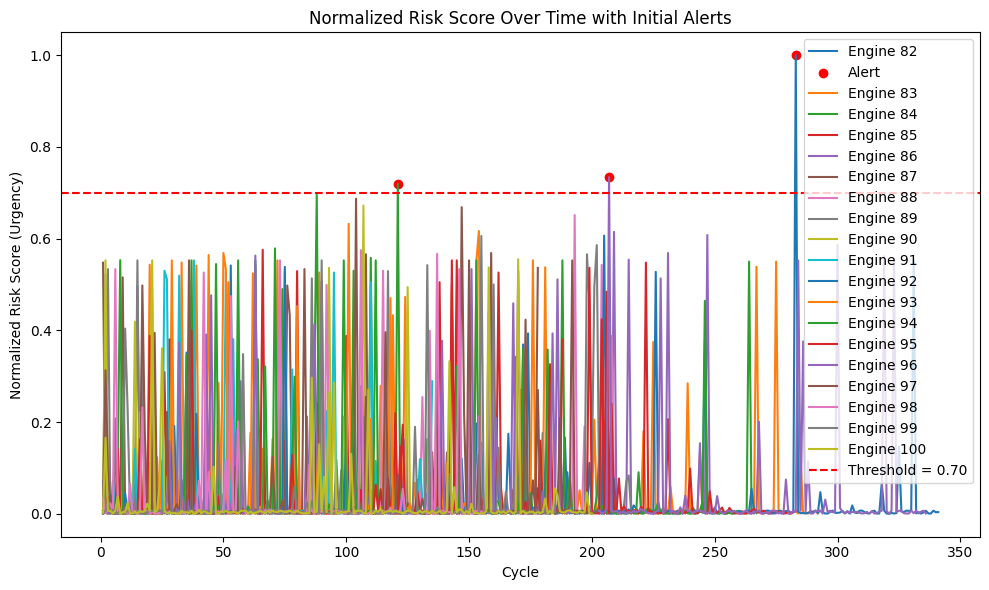

In [10]:
# # Visualize Risk Scores Over Time (Initial Threshold)
plt.figure(figsize=(10, 6))
for engine in df_tail['Engine no'].unique():
    engine_data = df_tail[df_tail['Engine no'] == engine]
    plt.plot(engine_data['cycle'], engine_data['Risk_Score'], label=f'Engine {engine}')
    alert_points = engine_data[engine_data['Maintenance_Alert']]
    plt.scatter(alert_points['cycle'], alert_points['Risk_Score'], color='red', marker='o', label='Alert' if engine == df_tail['Engine no'].unique()[0] else "")

plt.xlabel('Cycle')
plt.ylabel('Normalized Risk Score (Urgency)')
plt.title('Normalized Risk Score Over Time with Initial Alerts')
plt.axhline(initial_alert_threshold, color='red', linestyle='--', label=f'Threshold = {initial_alert_threshold:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Refining Threshold

In [11]:
# # Refine Alert Threshold using Percentile
percentile_threshold = 90
dynamic_threshold = np.percentile(normalized_scores, percentile_threshold)
dynamic_alerts = normalized_scores > dynamic_threshold
df_tail['Maintenance_Alert_Dynamic'] = dynamic_alerts


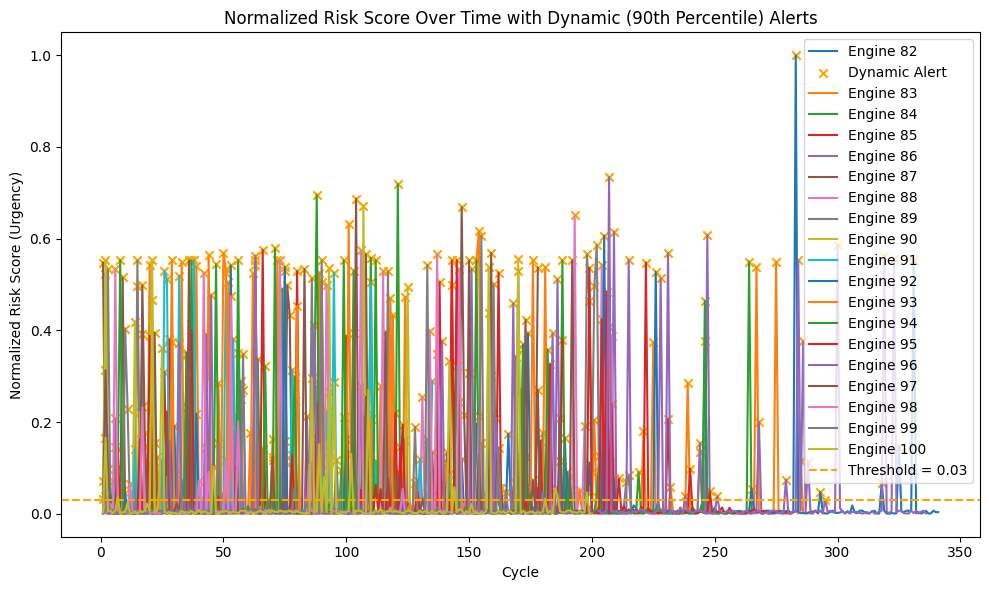

In [12]:
plt.figure(figsize=(10, 6))
for engine in df_tail['Engine no'].unique():
    engine_data = df_tail[df_tail['Engine no'] == engine]
    plt.plot(engine_data['cycle'], engine_data['Risk_Score'], label=f'Engine {engine}')
    alert_points = engine_data[engine_data['Maintenance_Alert_Dynamic']]
    plt.scatter(alert_points['cycle'], alert_points['Risk_Score'], color='orange', marker='x', label='Dynamic Alert' if engine == df_tail['Engine no'].unique()[0] else "")

plt.xlabel('Cycle')
plt.ylabel('Normalized Risk Score (Urgency)')
plt.title(f'Normalized Risk Score Over Time with Dynamic ({percentile_threshold}th Percentile) Alerts')
plt.axhline(dynamic_threshold, color='orange', linestyle='--', label=f'Threshold = {dynamic_threshold:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# # Define "True" High-Risk Situations for Evaluation (Example based on RUL < k)
k_rul_threshold = 30 # Consider engines with less than 30 cycles left as high-risk (This requires RUL in y_test)
# Assuming y_test represents RUL directly. If not, adjust accordingly.
y_true_high_risk = (y_test.values.flatten() < k_rul_threshold).astype(int)

In [14]:
# # Evaluate Performance with Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_true_high_risk, normalized_scores)
avg_precision = average_precision_score(y_true_high_risk, normalized_scores)

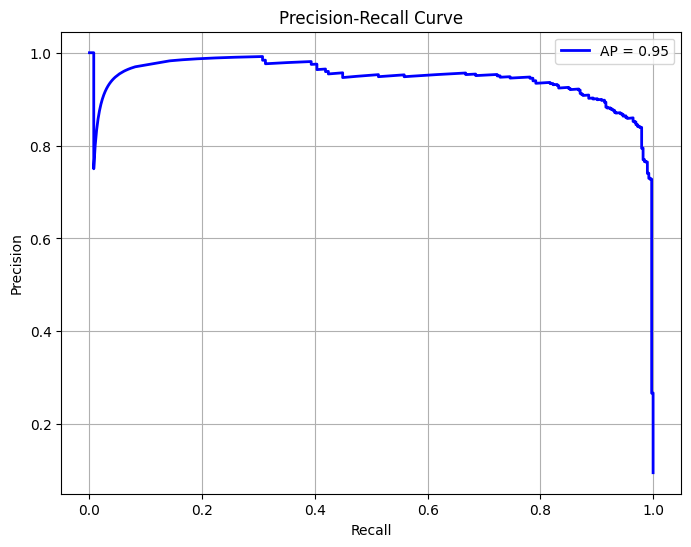

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

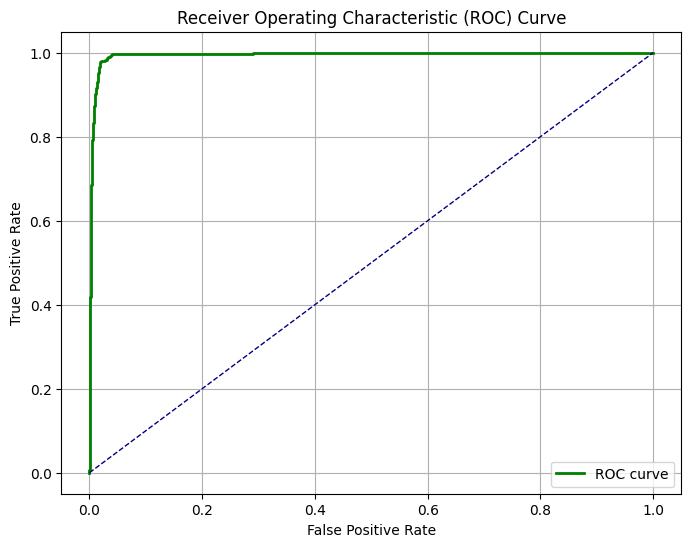

In [16]:
# # Evaluate Performance with ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true_high_risk, normalized_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [17]:
# # Choosing a Threshold based on PR or ROC (Example - you might need more sophisticated methods)
# For example, find the threshold that maximizes F1-score (harmonic mean of Precision and Recall)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_f1_index = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[best_f1_index]
print(f"Optimal Precision-Recall Threshold (based on F1): {optimal_threshold_pr:.3f}")

# Apply this optimal threshold
optimal_alerts_pr = normalized_scores > optimal_threshold_pr
df_tail['Maintenance_Alert_Optimal_PR'] = optimal_alerts_pr

Optimal Precision-Recall Threshold (based on F1): 0.021


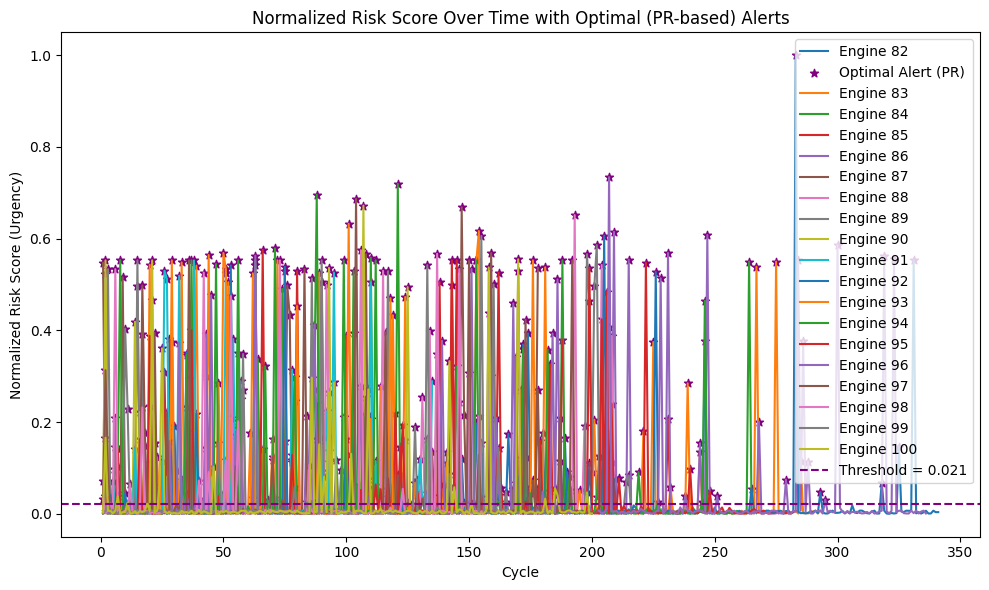

Risk score calculation, normalization, thresholding, and visualization complete.


In [18]:
plt.figure(figsize=(10, 6))
for engine in df_tail['Engine no'].unique():
    engine_data = df_tail[df_tail['Engine no'] == engine]
    plt.plot(engine_data['cycle'], engine_data['Risk_Score'], label=f'Engine {engine}')
    alert_points = engine_data[engine_data['Maintenance_Alert_Optimal_PR']]
    plt.scatter(alert_points['cycle'], alert_points['Risk_Score'], color='purple', marker='*', label='Optimal Alert (PR)' if engine == df_tail['Engine no'].unique()[0] else "")

plt.xlabel('Cycle')
plt.ylabel('Normalized Risk Score (Urgency)')
plt.title(f'Normalized Risk Score Over Time with Optimal (PR-based) Alerts')
plt.axhline(optimal_threshold_pr, color='purple', linestyle='--', label=f'Threshold = {optimal_threshold_pr:.3f}')
plt.legend()
plt.tight_layout()
plt.show()

print("Risk score calculation, normalization, thresholding, and visualization complete.")
# You would add unit tests in a separate file or at the end of this script if needed.